# 1.Setup Mario

In [5]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [6]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env.action_space

Discrete(256)

In [7]:
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env.action_space

Discrete(7)

In [8]:
env.observation_space.shape

(240, 256, 3)

In [9]:
env.action_space.sample()

3

In [10]:
# # Create a flag - restart or not
# done = True
# for step in range(100000): # looping through the frames so that we know what happens.
#     if done: 
#         env.reset() # this starts the game
#     state, reward, terminated, truncated, info = env.step(env.action_space.sample()) #step is to do an action and randomely take a step 
#     done = terminated or truncated
#     # Show the game on the screen
#     env.render()

# env.close()

In [11]:
state = env.reset()

In [12]:
env.step(1)[0]

array([[[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       ...,

       [[240, 208, 176],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [  0,   0,   0]],

       [[240, 208, 176],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[228,  92,  16],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [228,  92,  16]]

In [13]:
env.step(1)[1]

0.0

In [14]:
env.step(1)[3]

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 40,
 'y_pos': 79}

In [15]:
env.close()

# 2. Preprocess Environment

In [16]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
# FrameStack: Allow us to capture a COUPLE of frames while playing the game and stack them above each others so that we know what's happening
# GrayScaleObservation: Convert colored game into gray to get less data to process.
from gym.wrappers import FrameStack, GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import matplotlib to show the impact of the frame stacking
from matplotlib import pyplot as plt

In [17]:
# 1. Create the base env
env = gym_super_mario_bros.make('SuperMarioBros-v0')

# 2. Simplify the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [18]:
state = env.reset()
state.shape

(240, 256, 3)

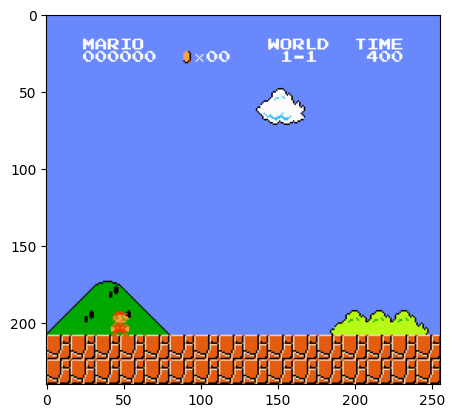

In [19]:
plt.imshow(state)

In [20]:

# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)

In [21]:
state = env.reset()
state.shape

(240, 256, 1)

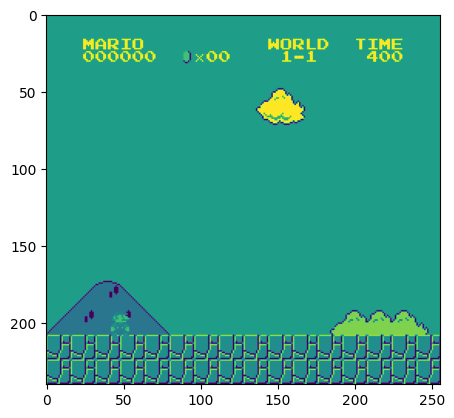

In [22]:
plt.imshow(state)

In [23]:
# 4. Wrap inside the Dummy Environment 
env = DummyVecEnv([lambda:env])

In [24]:
state = env.reset()
state.shape

(1, 240, 256, 1)

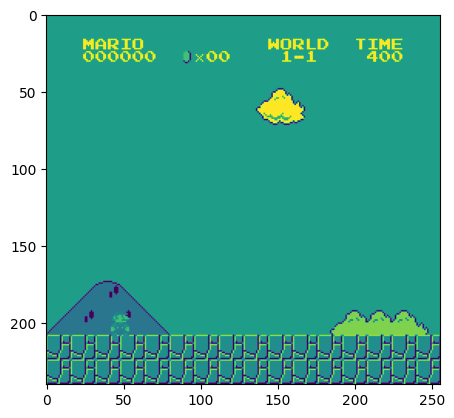

In [25]:
plt.imshow(state[0])

In [26]:
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [27]:
state = env.reset()
state.shape

(1, 240, 256, 4)

In [28]:
state, reward, done, info = env.step([5])

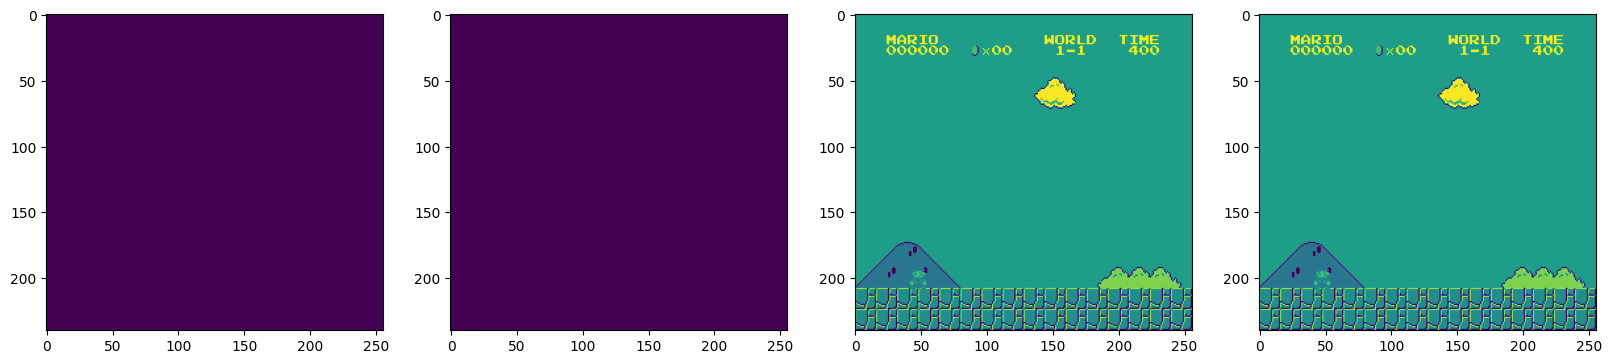

In [29]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])

plt.show()

# 3. Train the RL Model

In [30]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [31]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def __init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    
    def _on_step(self):
        if self.n_calls % self.check_freq==0:
            model_path = os.path.join(self.save_path,'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [32]:
CHECKPOINT_DIR ='./train/'
LOG_DIR = './logs/'

In [33]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [34]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [35]:
# model.learn(total_timesteps=100000, callback=callback)

# 4. Test it out

In [36]:
# Load model
model = PPO.load('./train/best_model_100000')

In [37]:
state = env.reset()
while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

c:\Users\abdel\anaconda3\envs\mraioRL37\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


KeyboardInterrupt: 